# Dropout

### Import necessary  libraries

We use GPUs for deep learning. If you want to try our code in CPU, remove all `.cuda()` in the notebook.

In [12]:
%env CUDA_VISIBLE_DEVICES=1
import numpy as np
import pandas as pd
from copy import deepcopy
import time

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D

import seaborn as sns
%matplotlib inline

import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

env: CUDA_VISIBLE_DEVICES=1


### Load MNIST Data

In [2]:
transform = transforms.Compose([transforms.ToTensor(), \
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.MNIST(root='data/', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='data/', train=False, transform=transform)

### Dropout Implementation

We should multiply the dropout output by $\frac{1}{1-p}$ where $p$ is the dropout rate to compensate for the dropped neurons. We implemented a dropout layer below, it should have same functionality as `nn.Dropout` in Pytorch.

In [3]:
class MyDropout(nn.Module):
    def __init__(self, p=0.5):
        super(MyDropout, self).__init__()
        self.p = p
        if self.p < 1:
            self.multiplier_ = 1.0 / (1.0-p)
        else:
            self.multiplier_ = 0.0
    def forward(self, input):
        if not self.training:
            return input
        selected_ = torch.Tensor(input.shape).uniform_(0,1)>self.p
        #selected_num = torch.sum(selected_)
        #if selected_num > 0:
        #    multiplier_ = torch.numel(selected_)/selected_num
        #else:
        #    multiplier_ = 0
        if input.is_cuda:
            selected_ = Variable(selected_.type(torch.cuda.FloatTensor), requires_grad=False)
        else:
            selected_ = Variable(selected_.type(torch.FloatTensor), requires_grad=False)
        return torch.mul(selected_,input) * self.multiplier_

### Build the Network

We use the code below to build the network as described in the paper.

In [4]:
def getData(testloader):
    return iter(testloader).next()

def accuracy_score(y_true, y_pred, verbose=False):
    if not verbose:
        return np.mean(y_true == y_pred)
    else:
        return np.array([np.mean(y_pred_test[y_test == i] == i) for i in range(10)])
    
class MLP(nn.Module):
    def __init__(self, hidden_layers=[800, 800], droprates=[0, 0]):
        super(MLP, self).__init__()
        self.model = nn.Sequential()
        self.model.add_module("dropout0",MyDropout(p=droprates[0]))
        self.model.add_module("input", nn.Linear(28*28, hidden_layers[0]))
        self.model.add_module("tanh", nn.Tanh())
        for i,d in enumerate(hidden_layers[:-1]):
            self.model.add_module("dropout_hidden"+str(i+1), MyDropout(p=droprates[1]))
            self.model.add_module("hidden"+str(i+1), nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            self.model.add_module("tanh_hidden"+str(i+1), nn.Tanh())
        self.model.add_module("final",nn.Linear(hidden_layers[-1], 10))
        #self.model.add_module("logsoftmax", nn.LogSoftmax(dim=1))
        
        
    def forward(self, x):
        x = x.view(x.shape[0], 28*28)
        x = self.model(x)
        return x
    
class MLPClassifier:
    def __init__(self, hidden_layers=[800, 800], droprates=[0, 0], batch_size=100, max_epoch=10, \
                 lr=0.1, momentum=0):
        self.hidden_layers = hidden_layers
        self.droprates = droprates
        self.batch_size = batch_size
        self.max_epoch = max_epoch
        self.model = MLP(hidden_layers=hidden_layers, droprates=droprates)
        self.model.cuda()
        #self.criterion = nn.NLLLoss()
        self.criterion = nn.CrossEntropyLoss().cuda()
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr, momentum=momentum)
        self.loss_ = []
        self.test_accuracy = []
        self.test_error = []
        
    def fit(self, trainset, testset, verbose=True):
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=self.batch_size, shuffle=True)
        testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=False)
        X_test, y_test = getData(testloader)
        X_test = X_test.cuda()
        print(self)
        for epoch in range(self.max_epoch):
            running_loss = 0
            for i, data in enumerate(trainloader, 0):
                inputs, labels = data
                inputs, labels = Variable(inputs).cuda(), Variable(labels).cuda()
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.data[0]
            self.loss_.append(running_loss / len(trainloader))
            if verbose:
                print('Epoch {} loss: {}'.format(epoch+1, self.loss_[-1]))
            y_test_pred = self.predict(X_test).cpu()
            self.test_accuracy.append(np.mean(y_test == y_test_pred))
            self.test_error.append(int(len(testset)*(1-self.test_accuracy[-1])))
            if verbose or epoch + 1 == self.max_epoch:
                print('Test error: {}; test accuracy: {}'.format(self.test_error[-1], self.test_accuracy[-1]))
        print('Finished Training.')
        return self
    
    def predict(self, x):
        model = self.model.eval()
        outputs = model(Variable(x))
        _, pred = torch.max(outputs.data, 1)
        model = self.model.train()
        return pred
    
    def __str__(self):
        return 'Hidden layers: {}; dropout rates: {}'.format(self.hidden_layers, self.droprates)

The paper tried three networks. One with no dropout, one with dropout in hidden layers and one with dropout in both hidden layers and input. The training takes really long time. We recommend using GPU to reproduce our results.

You can set `verbose=True` to see loss and accuracy of each epoch.

In [5]:
hidden_layers = [800, 800]
mlp1 = [MLPClassifier(hidden_layers, droprates=[0, 0], max_epoch=1500), 
        MLPClassifier(hidden_layers, droprates=[0, 0.5], max_epoch=1500),
        MLPClassifier(hidden_layers, droprates=[0.2, 0.5], max_epoch=1500)]

In [6]:
%%time

print(mlp1[0].model)
mlp1[0].fit(trainset, testset,verbose=False);

MLP(
  (model): Sequential(
    (dropout0): MyDropout(
    )
    (input): Linear(in_features=784, out_features=800)
    (tanh): Tanh()
    (dropout_hidden1): MyDropout(
    )
    (hidden1): Linear(in_features=800, out_features=800)
    (tanh_hidden1): Tanh()
    (final): Linear(in_features=800, out_features=10)
  )
)
Hidden layers: [800, 800]; dropout rates: [0, 0]
Test error: 169; test accuracy: 0.9831
Finished Training.
CPU times: user 2h 7min 47s, sys: 3min 25s, total: 2h 11min 12s
Wall time: 2h 11min 8s


In [7]:
%%time

print(mlp1[1].model)
mlp1[1].fit(trainset, testset,verbose=False);

MLP(
  (model): Sequential(
    (dropout0): MyDropout(
    )
    (input): Linear(in_features=784, out_features=800)
    (tanh): Tanh()
    (dropout_hidden1): MyDropout(
    )
    (hidden1): Linear(in_features=800, out_features=800)
    (tanh_hidden1): Tanh()
    (final): Linear(in_features=800, out_features=10)
  )
)
Hidden layers: [800, 800]; dropout rates: [0, 0.5]
Test error: 149; test accuracy: 0.9851
Finished Training.
CPU times: user 2h 8min 3s, sys: 3min 24s, total: 2h 11min 27s
Wall time: 2h 11min 24s


In [8]:
%%time

print(mlp1[2].model)
mlp1[2].fit(trainset, testset,verbose=False);

MLP(
  (model): Sequential(
    (dropout0): MyDropout(
    )
    (input): Linear(in_features=784, out_features=800)
    (tanh): Tanh()
    (dropout_hidden1): MyDropout(
    )
    (hidden1): Linear(in_features=800, out_features=800)
    (tanh_hidden1): Tanh()
    (final): Linear(in_features=800, out_features=10)
  )
)
Hidden layers: [800, 800]; dropout rates: [0.2, 0.5]
Test error: 112; test accuracy: 0.9887
Finished Training.
CPU times: user 1h 59min 20s, sys: 3min 13s, total: 2h 2min 34s
Wall time: 2h 2min 29s


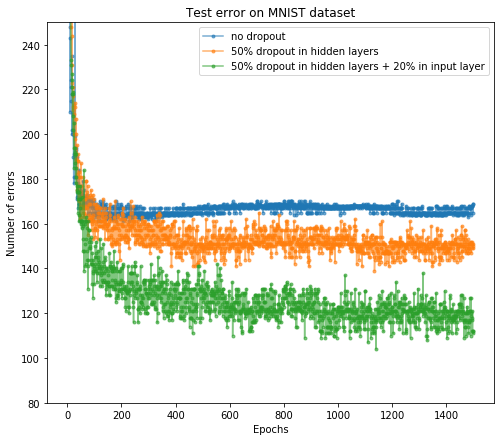

In [9]:
results = [(mlp.loss_, mlp.test_accuracy, mlp.test_error) for mlp in mlp1]
labels = ['no dropout', '50% dropout in hidden layers', '50% dropout in hidden layers + 20% in input layer']

plt.figure(figsize=(8, 7))
for i, r in enumerate(results):
    plt.plot(range(1, len(r[2])+1), r[2], '.-', label=labels[i], alpha=0.6);
plt.ylim([80, 250]);
plt.legend(loc=1);
plt.xlabel('Epochs');
plt.ylabel('Number of errors');
plt.title('Test error on MNIST dataset');

The result above is similar to what is described in the paper. As we can see, dropout works.

# Dropout as Bayesian Approximation in Regression Task

We use keras for this task. Keras has `Dropout` implementation same to what we implemented above.

First load `keras` libraries and `pymc3` library.

In [13]:
import sys

import warnings
warnings.filterwarnings("ignore")
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.models import load_model

import pymc3 as pm
import h5py

Using TensorFlow backend.


Load data:

In [3]:
f = h5py.File('train_co2.h5', 'r')
data_train = np.concatenate((f['data'].value, f['label'].value), axis=1)
f.close()
X_train = data_train[:, 0].reshape(-1, 1)
y_train = data_train[:, 1].reshape(-1, 1)

f = h5py.File('test_co2.h5', 'r')
data_test = np.concatenate((f['data'].value, f['label'].value), axis=1)
f.close()

X_test = np.arange(-1.72, 3.51, 0.01).reshape(-1, 1)

Plot the training data.

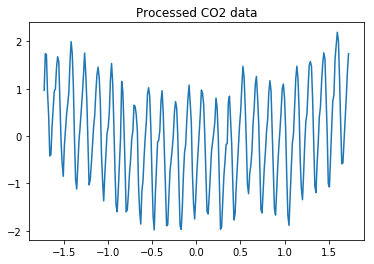

In [5]:
plt.plot(data_train[:, 0], data_train[:, 1]);
plt.title('Processed CO2 data');

Build the network

In [20]:
class FFNN2:
    def __init__(self, hidden_layers=[1024, 1024, 1024, 1024, 1024], droprate=0.2, activation='relu'):
        model = Sequential()
        model.add(Dense(hidden_layers[0], activation=activation, input_shape=(1, ), kernel_initializer='lecun_uniform'))
        for d in hidden_layers[1:]:
            model.add(Dropout(droprate))
            model.add(Dense(d, activation=activation, kernel_initializer='lecun_uniform'))
        model.add(Dropout(droprate))
        model.add(Dense(1))
        self.model = model
        
    def fit(self, X_train, y_train, lr=0.0001, epochs=300000, batch_size=100, verbose=0):
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.model.compile(loss='mean_squared_error', optimizer=Adam(lr=lr))
        self.result = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
        return self
    
def predict(model, X, T=10000):
    # Reference: https://github.com/yaringal/DropoutUncertaintyExps/blob/master/bostonHousing/net/net/net.py
    standard_pred = model.predict(X)
    predict_stochastic = K.function([model.layers[0].input, K.learning_phase()], [model.layers[-1].output])
    Yt_hat = np.array([predict_stochastic([X, 1]) for _ in range(T)]).squeeze()
    return standard_pred, Yt_hat

In [6]:
%%time

ffnn2_relu = FFNN2(activation='relu').fit(X_train, y_train, verbose=False)
ffnn2_relu.model.save('co2_regression_MC_relu.h5')

CPU times: user 1h 32min 59s, sys: 23min 19s, total: 1h 56min 19s
Wall time: 1h 10min 18s


In [21]:
%%time

model = load_model('co2_regression_MC_relu.h5')
y_relu_pred, y_hat = predict(model, X_test)
y_relu_mc = y_hat.mean(axis=0)
y_relu_mc_std = y_hat.std(axis=0)

CPU times: user 15.5 s, sys: 7.72 s, total: 23.2 s
Wall time: 18.1 s


In [12]:
%%time

ffnn2_tanh = FFNN2(activation='tanh').fit(X_train, y_train, verbose=False)
ffnn2_tanh.model.save('co2_regression_MC_tanh.h5')

CPU times: user 1h 32min 24s, sys: 22min 12s, total: 1h 54min 37s
Wall time: 1h 8min 38s


In [22]:
%%time

model = load_model('co2_regression_MC_tanh.h5')
y_tanh_pred, y_hat = predict(model, X_test)
y_tanh_mc = y_hat.mean(axis=0)
y_tanh_mc_std = y_hat.std(axis=0)

CPU times: user 16.3 s, sys: 5.64 s, total: 22 s
Wall time: 16.8 s


Build a Bayesian model.

In [4]:
with pm.Model() as pm_model:
    l = pm.HalfCauchy('l', 0.05)
    eta = pm.HalfCauchy('eta', 1)
    sigma = pm.HalfCauchy('sigma', 0.1)
        
    gp = pm.gp.Marginal(cov_func=(eta ** 2) * pm.gp.cov.ExpQuad(1, l))
    obs = gp.marginal_likelihood('obs', X=X_train, y=y_train.squeeze(), noise=sigma, is_observed=True)

Fit it.

In [5]:
%%time

with pm_model:
    step = pm.NUTS(target_accept=0.95)
    trace1 = pm.sample(5000, tune=2000, step=step, njobs=2)

/home/zeyu/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_log__, eta_log__, l_log__]
100%|██████████| 7000/7000 [14:59<00:00,  7.78it/s]


CPU times: user 5.85 s, sys: 2.56 s, total: 8.41 s
Wall time: 15min 3s


Check convergence.

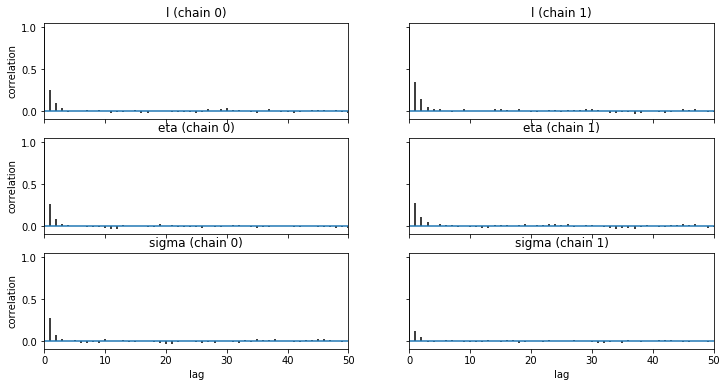

In [16]:
pm.autocorrplot(trace1, max_lag=50);

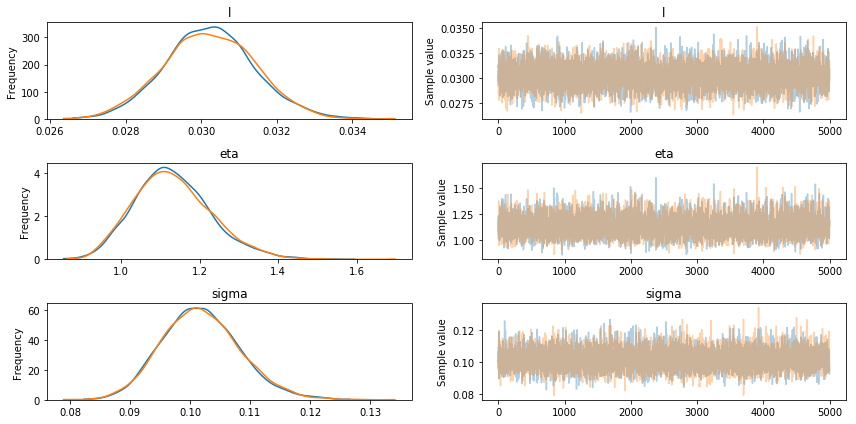

In [17]:
pm.traceplot(trace1);

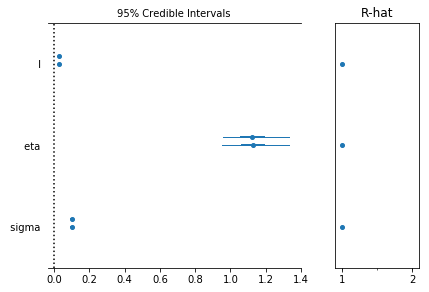

In [18]:
pm.forestplot(trace1);

In [11]:
with pm_model:
    y_gp = gp.conditional('y_pred', Xnew=X_test, pred_noise=True)
    gp_samples = pm.sample_ppc(trace1, vars=[y_gp], samples=10000)
ppc = gp_samples['y_pred']
y_gp_pred = ppc.mean(axis=0)
y_gp_std = ppc.std(axis=0)

100%|██████████| 10000/10000 [10:27<00:00, 15.95it/s]


Generate plot like in the paper.

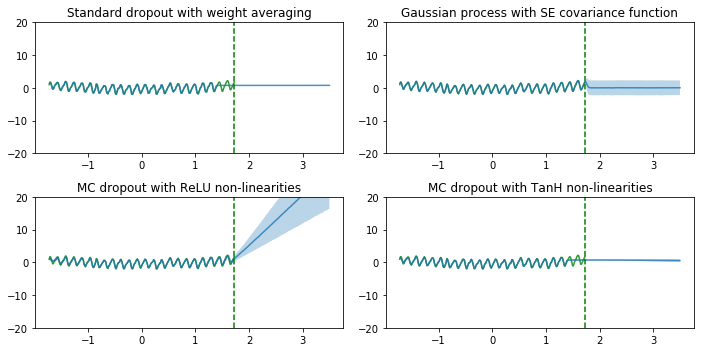

In [23]:
plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.plot(X_train.squeeze(), y_train.squeeze(), 'g', alpha=0.8);
plt.plot(X_test.squeeze(), y_tanh_pred, alpha=0.8);
plt.axvline(X_train.squeeze()[-1], color='g',linestyle='--');
plt.title('Standard dropout with weight averaging');
plt.ylim([-20, 20]);

plt.subplot(2, 2, 2)
plt.plot(X_train.squeeze(), y_train.squeeze(), 'g', alpha=0.8);
plt.plot(X_test.squeeze(), y_gp_pred, alpha=0.8);
plt.axvline(X_train.squeeze()[-1], color='g',linestyle='--');
plt.fill_between(X_test.squeeze(), y_gp_pred-2*y_gp_std, y_gp_pred+2*y_gp_std, alpha=0.3);
plt.title('Gaussian process with SE covariance function');
plt.ylim([-20, 20]);

plt.subplot(2, 2, 3)
plt.plot(X_train.squeeze(), y_train.squeeze(), 'g', alpha=0.8);
plt.plot(X_test.squeeze(), y_relu_mc, alpha=0.8);
plt.axvline(X_train.squeeze()[-1], color='g',linestyle='--');
plt.fill_between(X_test.squeeze(), y_relu_mc-2*y_relu_mc_std, y_relu_mc+2*y_relu_mc_std, alpha=0.3);
plt.title('MC dropout with ReLU non-linearities');
plt.ylim([-20, 20]);

plt.subplot(2, 2, 4)
plt.plot(X_train.squeeze(), y_train.squeeze(), 'g', alpha=0.8);
plt.plot(X_test.squeeze(), y_tanh_mc, alpha=0.8);
plt.axvline(X_train.squeeze()[-1], color='g',linestyle='--');
plt.fill_between(X_test.squeeze(), y_tanh_mc-2*y_tanh_mc_std, y_tanh_mc+2*y_tanh_mc_std, alpha=0.3);
plt.title('MC dropout with TanH non-linearities');
plt.ylim([-20, 20]);

plt.tight_layout();